In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [12]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

In [13]:
from sklearn.linear_model import LogisticRegression

In [14]:
# Đánh giá mô hình
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    precision_recall_curve, average_precision_score,
    roc_auc_score, roc_curve,
    confusion_matrix,
    classification_report
)

In [15]:
from sklearn.model_selection import RandomizedSearchCV # tinh chỉnh
from scipy.stats import randint
from scipy.stats import loguniform

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
DATA_PATH = '/content/drive/MyDrive/DS102 - Machine Learning/Hotel/data/'

In [18]:
def evaluations(y_true, y_pred, y_proba, model_name, dataset):

  print("="*50)
  print(f'Model {model_name}, đánh giá trên tập {dataset}:')
  print("Accuracy :", accuracy_score(y_true, y_pred))
  print("Precision:", precision_score(y_true, y_pred))
  print("Recall   :", recall_score(y_true, y_pred))
  print("F1-score :", f1_score(y_true, y_pred))
  print("ROC-AUC  :", roc_auc_score(y_true, y_proba))
  print("Confusion matrix:")
  print(confusion_matrix(y_true, y_pred))
  print(classification_report(y_true, y_pred))

In [19]:
def plot_evaluations(y_true, y_pred, y_proba, model_name, dataset):

  fig, axes = plt.subplots(2,2, figsize=(15,8))
  axes = axes.flatten()

  # confusion matrix
  conf_matrix = confusion_matrix(y_true, y_pred)
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[0])
  axes[0].set_title(f'Confusion Matrix - {model_name}, {dataset}')
  axes[0].set_xlabel('Predicted')
  axes[0].set_ylabel('Actual')

  # precision - recall curve
  precision, recall, threshold = precision_recall_curve(y_true, y_proba)
  average_precison = average_precision_score(y_true, y_proba)
  axes[1].plot(recall, precision, linewidth=2, zorder=3)
  axes[1].set_title(f'Precision-Recall Curve - {model_name}, {dataset}\nAverage precision score: {average_precison:.4f}')
  axes[1].set_xlabel('Recall cho lớp Hủy')
  axes[1].set_ylabel('Precision cho lớp Hủy')
  axes[1].grid(True, alpha=0.5, zorder=0)

  # threshold - recall
  thesholds = np.linspace(0,1,100)
  recalls = [
      recall_score(y_true, (y_proba > threshold).astype(int))
      for threshold in thesholds
  ]
  axes[2].plot(thesholds, recalls, linewidth=2, zorder=3)
  axes[2].set_title(f'Threshold - Recall - {model_name}, {dataset}')
  axes[2].set_xlabel('Threshold')
  axes[2].set_ylabel('Recall cho lớp Hủy')
  axes[2].grid(True, alpha=0.5, zorder=0)

  # roc curve
  fpr, tpr, thresholds = roc_curve(y_true, y_proba)
  auc = roc_auc_score(y_true, y_proba)

  axes[3].plot(fpr, tpr, linewidth=2, zorder=3)
  axes[3].plot([0,1], [0,1], 'k--', zorder=1)
  axes[3].set_title(f'ROC Curve - {model_name}, {dataset}\nAUC: {auc:.4f}')
  axes[3].grid(True, alpha=0.5, zorder=0)
  axes[3].set_xlabel('False Positive Rate')
  axes[3].set_ylabel('True Positive Rate')

  plt.tight_layout()
  plt.show()

# Dữ liệu

In [20]:
X_train = pd.read_csv(DATA_PATH + 'X_train.csv')
X_dev = pd.read_csv(DATA_PATH + 'X_dev.csv')
X_test = pd.read_csv(DATA_PATH + 'X_test.csv')

y_train = pd.read_csv(DATA_PATH + 'y_train.csv')
y_dev = pd.read_csv(DATA_PATH + 'y_dev.csv')
y_test = pd.read_csv(DATA_PATH + 'y_test.csv')

# Biến đổi và mã hóa dữ liệu

In [21]:
log_cols = ['lead_time']
ohe_cols = ['market_segment', 'distribution_channel',
            'assigned_room_type', 'customer_type', 'hotel_type',
            'country_group']
ordinal_cols = [
    'previous_cancellations_group',
    'previous_bookings_not_canceled_group',
    'booking_changes_group',
    'days_in_waiting_list_group',
    'deposit_type'
]

ordinal_categories = [
    ['0', '1-5', '>5'],                 # previous_cancellations_group
    ['0', '1-5', '>5'],                 # previous_bookings_not_canceled_group
    ['0', '1-2', '>2'],                 # booking_changes_group
    ['no_wait', 'short', 'medium', 'long', 'very_long'],
    ['No Deposit', 'Refundable', 'Non Refund'] # không đặt cọc, có hoàn tiền , ko hoàn tiền
]

In [22]:
class LogTransformer(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self

  def transform(self, X):
    return np.log1p(X)

  def get_feature_names_out(self, input_features=None):
    return np.array([f'log_{feature}' for feature in input_features])


ohe_transformer = OneHotEncoder(
    drop='first',
    handle_unknown='ignore',
    sparse_output=False
)

ord_transformer = OrdinalEncoder(
    categories=ordinal_categories,
    handle_unknown='use_encoded_value',
    unknown_value=-1
)

In [23]:
preprocessor = ColumnTransformer(
    transformers=[
        ('log', LogTransformer(), log_cols),
        ('ohe', ohe_transformer, ohe_cols),
        ('ord', ord_transformer, ordinal_cols)
    ],
    remainder='passthrough'
)

In [24]:
preprocessor.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('log', LogTransformer(), ['lead_time']),
                                ('ohe',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['market_segment', 'distribution_channel',
                                  'assigned_room_type', 'customer_type',
                                  'hotel_type', 'country_group']),
                                ('ord',
                                 OrdinalEncoder(categories=[['0', '1-5', '>5'],
                                                            ['0', '1-5', '>5'],
                                                            ['0', '1-2', '>2'],
                                                            ['no_wait', 'short',
                                                             'medium', 'long',
                                                             'very_long'],
                                                            ['No Deposit',
                                                             'Refundable',
                                                             'Non Refund']],
                                                handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 ['previous_cancellations_group',
                                  'previous_bookings_not_canceled_group',
                                  'booking_changes_group',
                                  'days_in_waiting_list_group',
                                  'deposit_type'])])

Các cột sau khi đã được biến đổi và mã hóa

In [25]:
preprocessor.get_feature_names_out()

array(['log__log_lead_time', 'ohe__market_segment_Complementary',
       'ohe__market_segment_Corporate', 'ohe__market_segment_Direct',
       'ohe__market_segment_Groups', 'ohe__market_segment_Offline TA/TO',
       'ohe__market_segment_Online TA',
       'ohe__distribution_channel_Direct',
       'ohe__distribution_channel_GDS', 'ohe__distribution_channel_TA/TO',
       'ohe__distribution_channel_Undefined', 'ohe__assigned_room_type_B',
       'ohe__assigned_room_type_C', 'ohe__assigned_room_type_D',
       'ohe__assigned_room_type_E', 'ohe__assigned_room_type_F',
       'ohe__assigned_room_type_G', 'ohe__assigned_room_type_H',
       'ohe__assigned_room_type_I', 'ohe__assigned_room_type_K',
       'ohe__assigned_room_type_L', 'ohe__customer_type_Group',
       'ohe__customer_type_Transient',
       'ohe__customer_type_Transient-Party', 'ohe__hotel_type_Resort',
       'ohe__country_group_BEL', 'ohe__country_group_BRA',
       'ohe__country_group_CHE', 'ohe__country_group_CN',
      

In [26]:
# def randomized_searchCV(model, params, X_train, y_train, scoring='recall', n_iter=30, cv=5, random_state = 42, n_jobs = -1):
#   random_search = RandomizedSearchCV(
#       estimator=model,
#       param_distributions=params,
#       scoring=scoring,
#       n_iter=n_iter,
#       cv=cv,
#       random_state=random_state,
#       n_jobs=n_jobs,
#       verbose=1
#   )
#   random_search.fit(X_train, y_train)
#   return random_search

# Mô hình Logistic Regression

## Huấn luyện

In [27]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression())
])

In [28]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('log', LogTransformer(),
                                                  ['lead_time']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['market_segment',
                                                   'distribution_channel',
                                                   'assigned_room_type',
                                                   'customer_type',
                                                   'hotel_type',
                                                   'country_group']),
                                                 ('ord',
                                                  OrdinalEncoder(categories=[[...
                                                                              '1-5',
                                                                              '>5'],
                                                                             ['0',
                                                                              '1-2',
                                                                              '>2'],
                                                                             ['no_wait',
                                                                              'short',
                                                                              'medium',
                                                                              'long',
                                                                              'very_long'],
                                                                             ['No '
                                                                              'Deposit',
                                                                              'Refundable',
                                                                              'Non '
                                                                              'Refund']],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['previous_cancellations_group',
                                                   'previous_bookings_not_canceled_group',
                                                   'booking_changes_group',
                                                   'days_in_waiting_list_group',
                                                   'deposit_type'])])),
                ('model', LogisticRegression())])

Dự đoán trên train



In [29]:
y_pred = pipeline.predict(X_train)
y_proba = pipeline.predict_proba(X_train)[:,1]

In [30]:
evaluations(y_train, y_pred, y_proba, 'Logistic Regression', 'train')

Model Logistic Regression, đánh giá trên tập train:
Accuracy : 0.8246511457557593
Precision: 0.8140279621963602
Recall   : 0.684644440794876
F1-score : 0.7437512265615244
ROC-AUC  : 0.9050037285185614
Confusion matrix:
[[46704  4762]
 [ 9601 20844]]
              precision    recall  f1-score   support

           0       0.83      0.91      0.87     51466
           1       0.81      0.68      0.74     30445

    accuracy                           0.82     81911
   macro avg       0.82      0.80      0.81     81911
weighted avg       0.82      0.82      0.82     81911



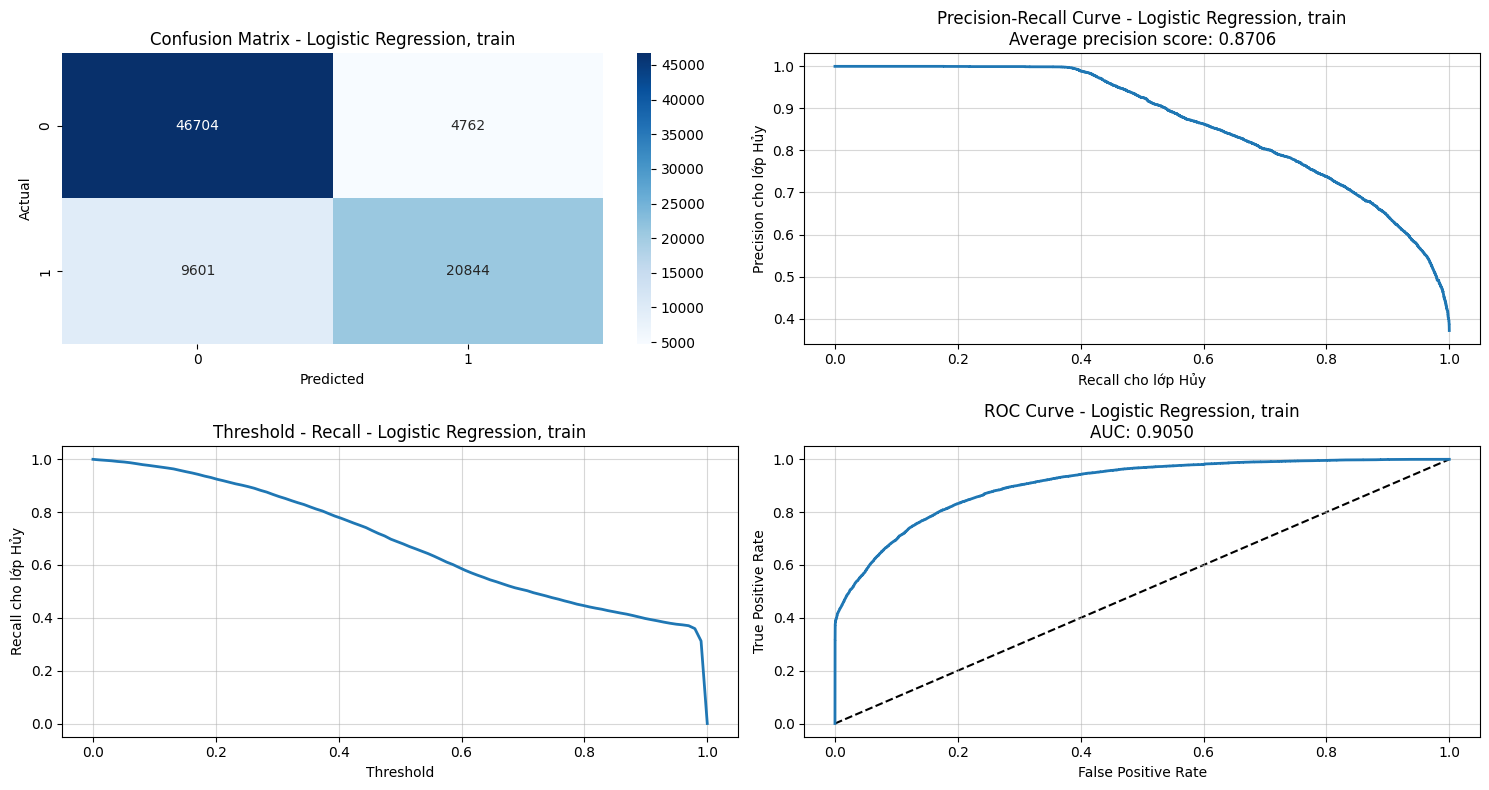

In [31]:
plot_evaluations(y_train, y_pred, y_proba, 'Logistic Regression', 'train')

Các trọng số

In [32]:
pipeline.named_steps['model'].coef_

array([[ 4.97160468e-01, -4.38903192e-01, -9.97608894e-01,
        -4.80670852e-01, -8.44557017e-01, -1.29356633e+00,
         5.26534523e-01, -9.48136073e-01, -1.21794448e+00,
        -6.27945618e-01, -2.94944334e-03,  4.02916943e-01,
         3.23005776e-01,  4.00710090e-02,  2.43420043e-01,
        -6.88673498e-02,  3.49689937e-03,  3.13210801e-01,
        -9.73464399e-02,  1.36472913e-01,  3.35480445e-02,
        -5.15265940e-01,  1.03521825e+00,  2.54222851e-01,
        -1.29135253e-01, -4.02889127e-01,  6.47735448e-01,
        -2.08088618e-01, -2.06118060e-01, -5.68953530e-01,
         5.69189832e-01, -2.08787717e-01, -2.09318837e-01,
        -2.12306818e-01,  6.21848448e-01, -4.01097621e-01,
         4.44382222e-01,  1.85854404e+00, -3.65613467e-01,
         1.13880155e-01,  3.60314398e+00, -2.18856358e+00,
        -6.47859130e-01, -7.93109558e-02,  2.22653408e+00,
        -5.99741429e+00, -7.47021036e-01, -6.95538287e-01,
        -7.47834975e-02,  1.36440007e-01,  1.61370347e-0

In [33]:
pipeline.named_steps['model'].intercept_

array([-3.13047581])

In [34]:
coef_df = pd.DataFrame({
    'feature': preprocessor.get_feature_names_out(),
    'coef': pipeline.named_steps['model'].coef_[0]
}).sort_values('coef', ascending = False) # sắp xếp giảm dần trọng số gắn với từng biến đầu vào

In [35]:
coef_df

,feature,coef
40,ord__previous_cancellations_group,3.603144
44,ord__deposit_type,2.226534
37,ohe__country_group_PRT,1.858544
22,ohe__customer_type_Transient,1.035218
26,ohe__country_group_BRA,0.647735
34,ohe__country_group_ITA,0.621848
30,ohe__country_group_ESP,0.569190
6,ohe__market_segment_Online TA,0.526535
0,log__log_lead_time,0.497160
36,ohe__country_group_Other,0.444382


## Đánh giá trên dev

### Trước khi tinh chỉnh

In [36]:
y_dev_pred = pipeline.predict(X_dev)
y_dev_proba = pipeline.predict_proba(X_dev)[:,1]

In [37]:
evaluations(y_dev, y_dev_pred, y_dev_proba, 'Logistic Regression', 'dev')

Model Logistic Regression, đánh giá trên tập dev:
Accuracy : 0.821682903207429
Precision: 0.8155745144309312
Recall   : 0.6800363251097321
F1-score : 0.741663915483658
ROC-AUC  : 0.9028633374493789
Confusion matrix:
[[9930 1016]
 [2114 4493]]
              precision    recall  f1-score   support

           0       0.82      0.91      0.86     10946
           1       0.82      0.68      0.74      6607

    accuracy                           0.82     17553
   macro avg       0.82      0.79      0.80     17553
weighted avg       0.82      0.82      0.82     17553



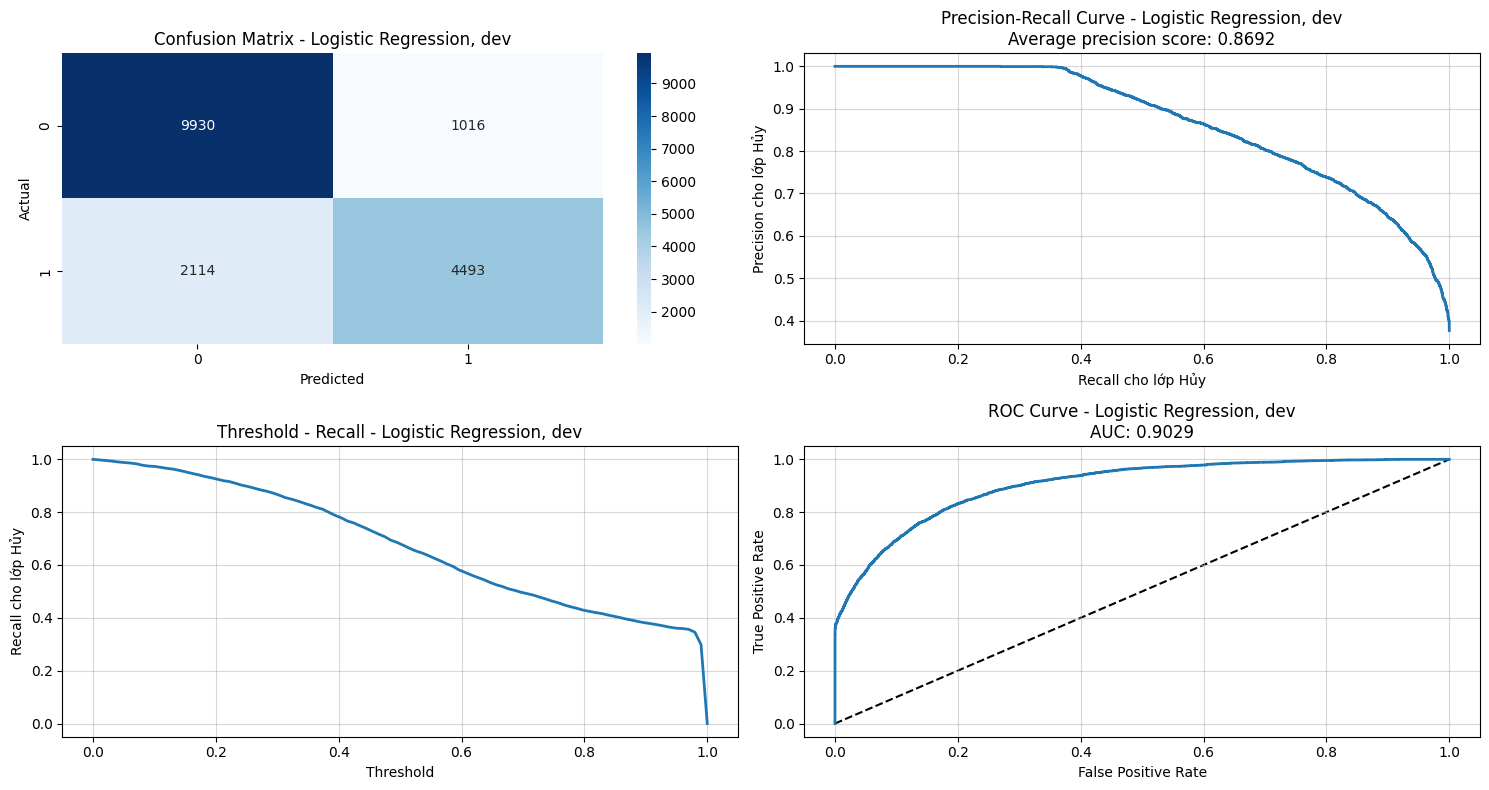

In [38]:
plot_evaluations(y_dev, y_dev_pred, y_dev_proba, 'Logistic Regression', 'dev')

Nhận xét:
- Mô hình có độ chính xác cao với số lượng TP và TN lớn, nhưng số FN khá cao, cho thấy mô hình bỏ sót nhiều trường hợp Huỷ.

- Precision ở mức tốt, tuy nhiên Recall khá thấp vì mô hình bỏ sót nhiều trường hợp Hủy. Vì bài toán nghiệp vụ cần recall cao nên mô hình cần được tinh chỉnh để bắt được nhiều trường hợp Hủy hơn.

- Khi giảm ngưỡng phân loại, mô hình bắt được nhiều trường hợp Huỷ hơn (tăng Recall), nhưng có thể làm giảm Precision.

- AUC cao cho thấy mô hình có khả năng phân biệt rất tốt giữa hai lớp. Đường cong ROC nằm xa đường chéo ngẫu nhiên, chứng tỏ hiệu suất mạnh mẽ.

#### Chọn ngưỡng

Quan sát đường cong Threshold - Recall:

threshold khoảng 0.3–0.4 → recall vẫn ~0.75–0.85

threshold > 0.6 → recall tụt mạnh (< 0.6)

threshold < 0.2 → recall cao nhưng precision sẽ rơi

Vì vậy chọn threshold khoảng 0.4 để recall cao trong khi precison vẫn ở mức chấp nhận được.


In [39]:
threshold = 0.4

y_dev_pred_opt = (y_dev_proba >= threshold).astype(int)

Kết quả đánh giá khi chọn ngưỡng là 0.4

In [40]:
evaluations(y_dev, y_dev_pred_opt, y_dev_proba, 'Logistic Regression', 'dev')

Model Logistic Regression, đánh giá trên tập dev:
Accuracy : 0.8194610607873298
Precision: 0.7490582439872501
Recall   : 0.7825034054790374
F1-score : 0.7654156488267081
ROC-AUC  : 0.9028633374493789
Confusion matrix:
[[9214 1732]
 [1437 5170]]
              precision    recall  f1-score   support

           0       0.87      0.84      0.85     10946
           1       0.75      0.78      0.77      6607

    accuracy                           0.82     17553
   macro avg       0.81      0.81      0.81     17553
weighted avg       0.82      0.82      0.82     17553



In [41]:
X_dev_wrong = X_dev[(y_dev_pred_opt != y_dev['is_canceled']) & y_dev['is_canceled'] == 1]

### Tinh chỉnh model

In [42]:
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('log', LogTransformer(),
                                                  ['lead_time']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['market_segment',
                                                   'distribution_channel',
                                                   'assigned_room_type',
                                                   'customer_type',
                                                   'hotel_type',
                                                   'country_group']),
                                                 ('ord',
                                                  OrdinalEncoder(categories=[[...
                                                                              '1-5',
                                                                              '>5'],
                                                                             ['0',
                                                                              '1-2',
                                                                              '>2'],
                                                                             ['no_wait',
                                                                              'short',
                                                                              'medium',
                                                                              'long',
                                                                              'very_long'],
                                                                             ['No '
                                                                              'Deposit',
                                                                              'Refundable',
                                                                              'Non '
                                                                              'Refund']],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['previous_cancellations_group',
                                                   'previous_bookings_not_canceled_group',
                                                   'booking_changes_group',
                                                   'days_in_waiting_list_group',
                                                   'deposit_type'])])),
                ('model', LogisticRegression())])

In [43]:
param_dist = {
    'model__penalty': ['l1', 'l2'],
    'model__C': loguniform(1e-4, 10),
    'model__solver': ['liblinear'],
    'model__class_weight': [None, 'balanced'],
    'model__max_iter': [300, 500, 800, 1000]
}

In [44]:
random_search_logistic = RandomizedSearchCV(
    pipeline,
    param_dist,
    scoring='f1',
    n_iter=30,
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

random_search_logistic.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('log',
                                                                               LogTransformer(),
                                                                               ['lead_time']),
                                                                              ('ohe',
                                                                               OneHotEncoder(drop='first',
                                                                                             handle_unknown='ignore',
                                                                                             sparse_output=False),
                                                                               ['market_segment',
                                                                                'distribution_channel',
                                                                                'assigned_room_type',
                                                                                'customer_type',
                                                                                'hotel_type',
                                                                                'country_group']),
                                                                              (...
                                                                                'deposit_type'])])),
                                             ('model', LogisticRegression())]),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'model__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7807f87dd2b0>,
                                        'model__class_weight': [None,
                                                                'balanced'],
                                        'model__max_iter': [300, 500, 800,
                                                            1000],
                                        'model__penalty': ['l1', 'l2'],
                                        'model__solver': ['liblinear']},
                   random_state=42, scoring='f1', verbose=1)

In [45]:
random_search_logistic.best_params_

{'model__C': np.float64(0.11462107403425033),
 'model__class_weight': 'balanced',
 'model__max_iter': 1000,
 'model__penalty': 'l2',
 'model__solver': 'liblinear'}

In [46]:
random_search_logistic.best_score_

np.float64(0.7667379894481074)

In [47]:
best_pipe = random_search_logistic.best_estimator_
log_reg = best_pipe.named_steps['model']
coef = log_reg.coef_        # shape: (1, n_features)
intercept = log_reg.intercept_
# coef > 0 → tăng xác suất class 1
# coef < 0 → giảm xác suất class 1

In [48]:
coef_df = pd.DataFrame({
    'feature': preprocessor.get_feature_names_out(),
    'coef': best_pipe.named_steps['model'].coef_[0]
}).sort_values('coef', ascending = False)

coef_df['odds_ratio'] = np.exp(coef_df['coef'])
coef_df['abs_log_odds'] = coef_df['coef'].abs()

In [49]:
coef_df['feature_clean'] = (
    coef_df['feature']
    .str.replace('log__', '', regex=False)
    .str.replace('ohe__', '', regex=False)
    .str.replace('ord__', '', regex=False)
)

### Sau khi tinh chỉnh

Với ngưỡng mặc định 0.5

In [50]:
y_dev_pred = best_pipe.predict(X_dev)
y_dev_proba = best_pipe.predict_proba(X_dev)[:,1]

In [51]:
evaluations(y_dev, y_dev_pred, y_dev_proba, 'Logistic Regression', 'dev')

Model Logistic Regression, đánh giá trên tập dev:
Accuracy : 0.8159289010425568
Precision: 0.7299101062380823
Recall   : 0.811109429393068
F1-score : 0.7683704925084236
ROC-AUC  : 0.9027656884128482
Confusion matrix:
[[8963 1983]
 [1248 5359]]
              precision    recall  f1-score   support

           0       0.88      0.82      0.85     10946
           1       0.73      0.81      0.77      6607

    accuracy                           0.82     17553
   macro avg       0.80      0.81      0.81     17553
weighted avg       0.82      0.82      0.82     17553



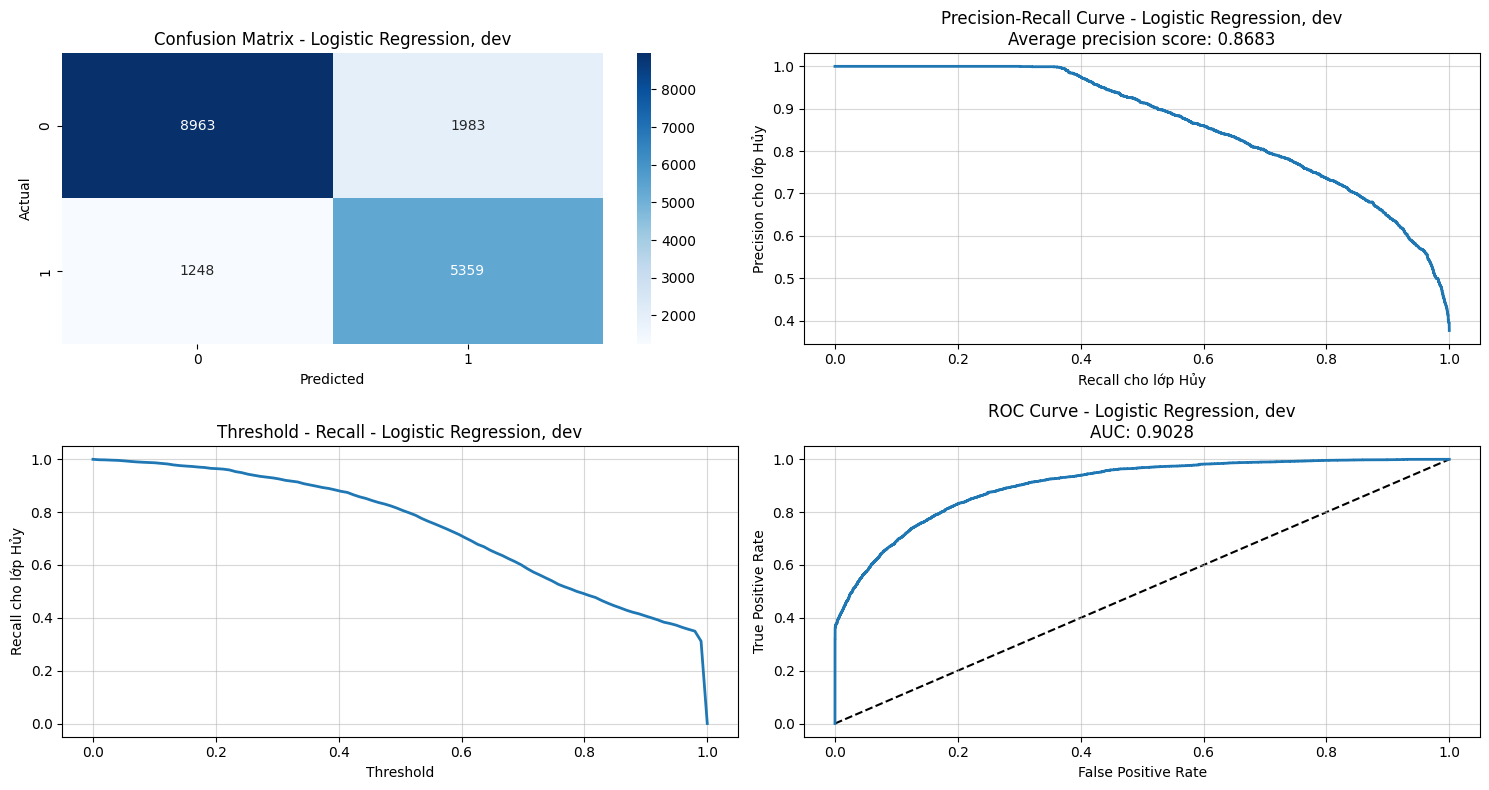

In [52]:
plot_evaluations(y_dev, y_dev_pred, y_dev_proba, 'Logistic Regression', 'dev')

Nhận xét:
- Mô hình có độ chính xác cao, với số lượng TP và TN lớn. Đặc biệt, số lượng FN đã giảm mạnh so với các lần trước, cho thấy mô hình ít bỏ sót các trường hợp Huỷ hơn.

- Precision và Recall vẫn duy trì ở mức cao và ổn định. Mặc dù có sự thay đổi nhẹ so với mô hình trước tinh chỉnh, sự khác biệt là không đáng kể, chứng tỏ mô hình có khả năng tổng quát tốt.

- Mô hình phản ứng tốt với việc điều chỉnh ngưỡng, trong nghiệp vụ có thể cân nhắc giảm ngưỡng để tăng Recall, chấp nhận giảm Precision.

- AUC vẫn duy trì ở mức rất cao, gần như không thay đổi so với mô hình chưa tinh chỉnh trên tập train. Điều này cho thấy mô hình có khả năng phân biệt mạnh mẽ giữa hai lớp và không bị suy giảm hiệu suất khi chuyển sang tập phát triển.

Với ngưỡng 0.4

In [53]:
threshold = 0.4
y_dev_pred_opt = (y_dev_proba >= threshold).astype(int)

In [54]:
evaluations(y_dev, y_dev_pred_opt, y_dev_proba, 'Logistic Regression', 'dev')

Model Logistic Regression, đánh giá trên tập dev:
Accuracy : 0.7912607531476101
Precision: 0.669235192639448
Recall   : 0.8807325563795974
F1-score : 0.7605541759247157
ROC-AUC  : 0.9027656884128482
Confusion matrix:
[[8070 2876]
 [ 788 5819]]
              precision    recall  f1-score   support

           0       0.91      0.74      0.81     10946
           1       0.67      0.88      0.76      6607

    accuracy                           0.79     17553
   macro avg       0.79      0.81      0.79     17553
weighted avg       0.82      0.79      0.79     17553



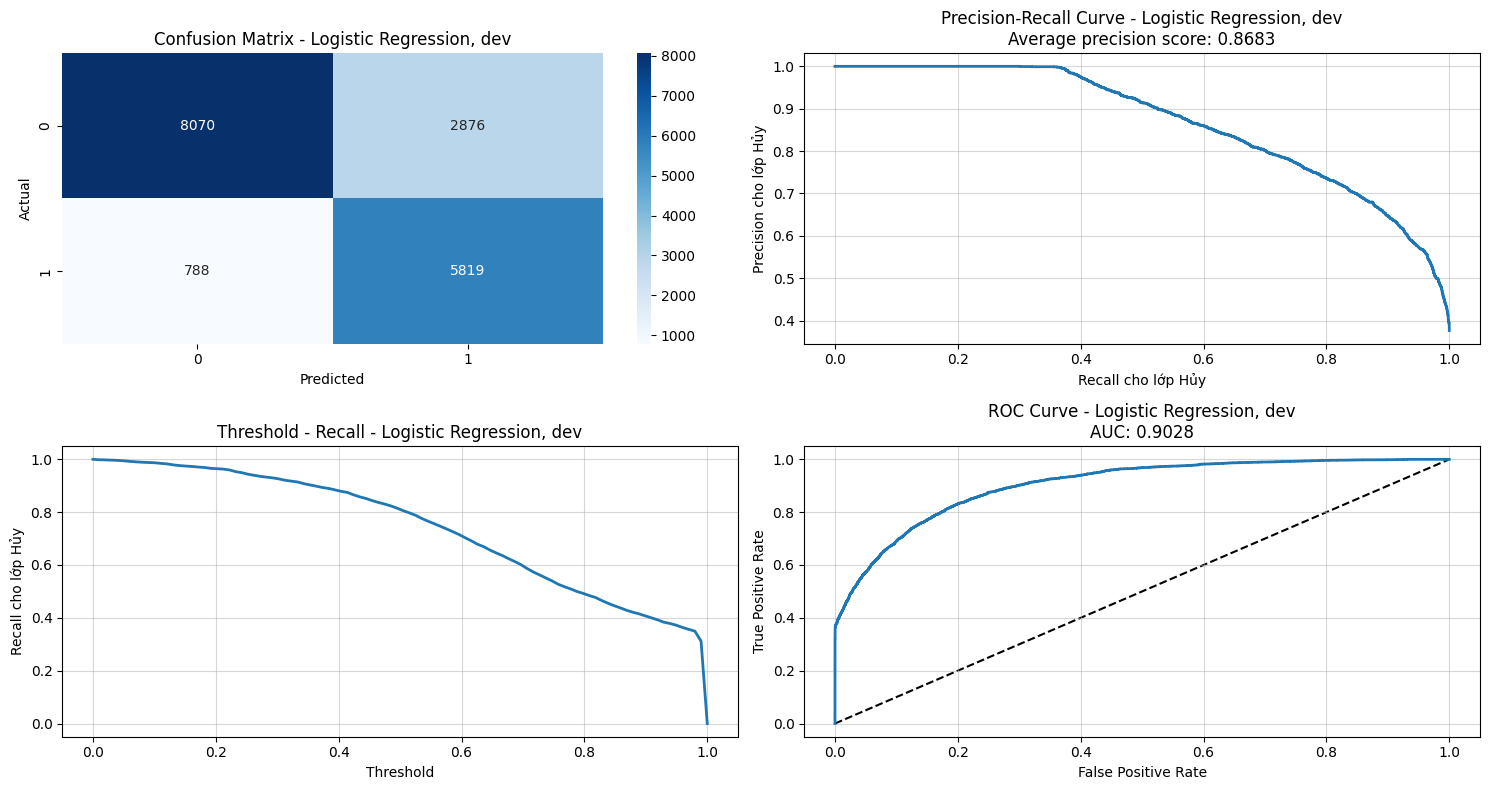

In [55]:
plot_evaluations(y_dev, y_dev_pred_opt, y_dev_proba, 'Logistic Regression', 'dev')

# Giải thích mô hình

## Hệ số và log odds

In [56]:
coef_df.head(15)

,feature,coef,odds_ratio,abs_log_odds,feature_clean
40,ord__previous_cancellations_group,3.022474,20.542055,3.022474,previous_cancellations_group
44,ord__deposit_type,2.070645,7.929935,2.070645,deposit_type
37,ohe__country_group_PRT,1.990077,7.316100,1.990077,country_group_PRT
22,ohe__customer_type_Transient,0.931639,2.538666,0.931639,customer_type_Transient
26,ohe__country_group_BRA,0.702819,2.019438,0.702819,country_group_BRA
34,ohe__country_group_ITA,0.644715,1.905443,0.644715,country_group_ITA
6,ohe__market_segment_Online TA,0.630002,1.877615,0.630002,market_segment_Online TA
30,ohe__country_group_ESP,0.599545,1.821290,0.599545,country_group_ESP
0,log__log_lead_time,0.483997,1.622548,0.483997,log_lead_time
36,ohe__country_group_Other,0.475762,1.609240,0.475762,country_group_Other


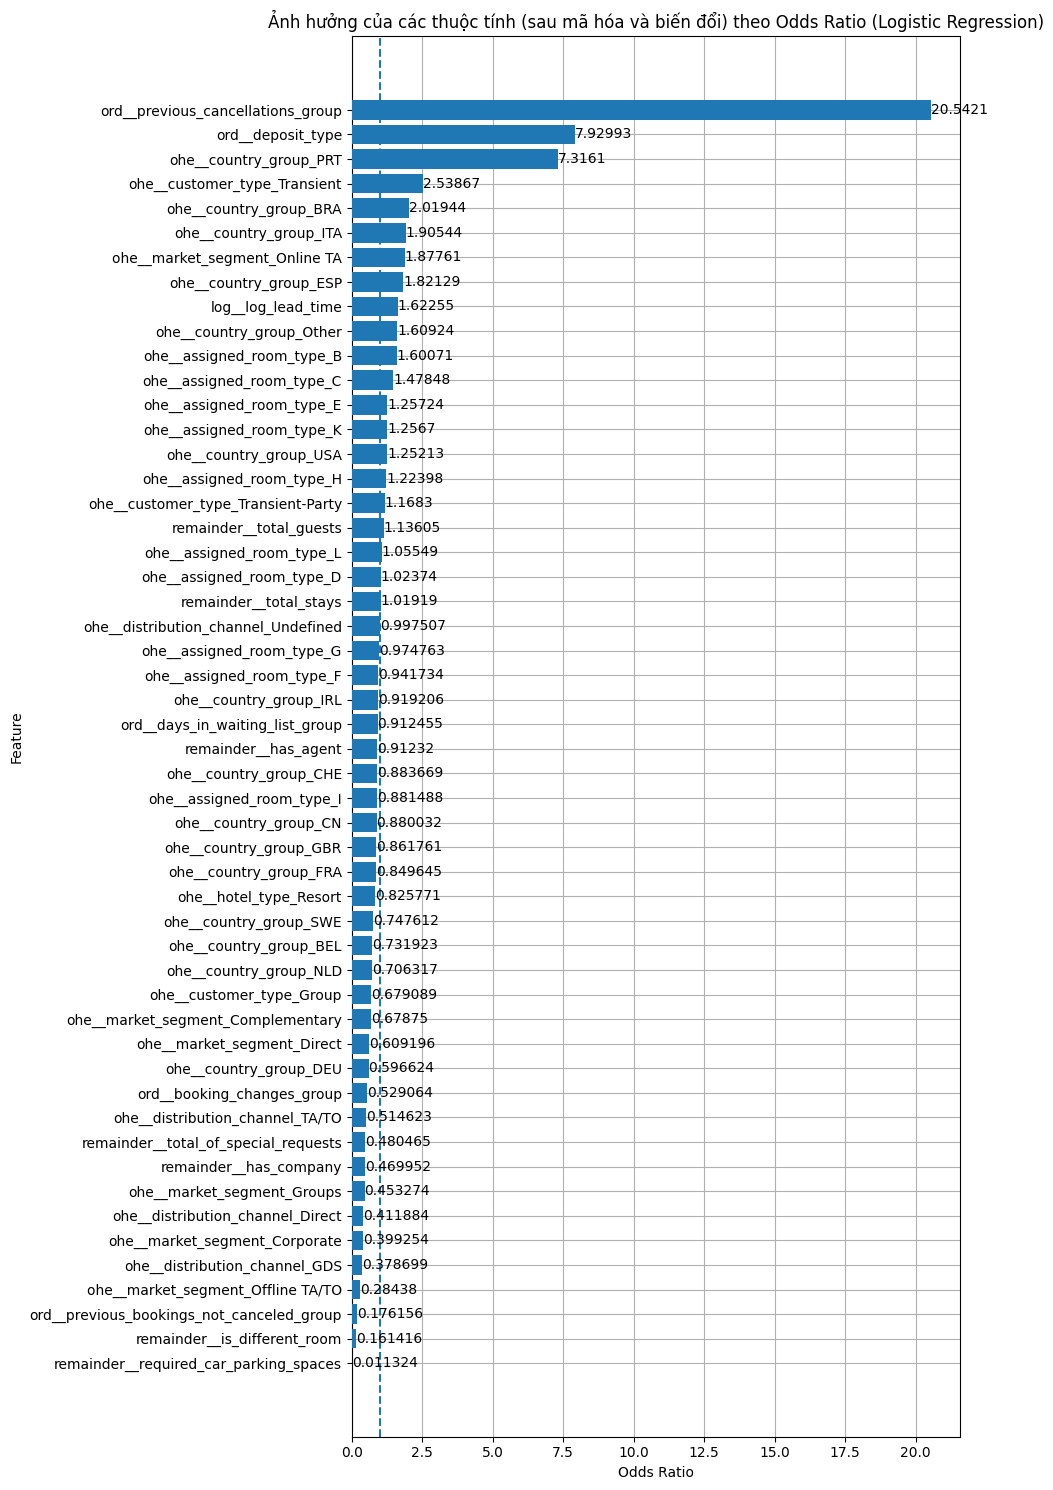

In [57]:
plt.figure(figsize=(10, 15))

plt.barh(
    coef_df['feature'],
    coef_df['odds_ratio'],
    zorder=3
)

plt.axvline(x=1, linestyle='--')  # odds = 1 (không ảnh hưởng)
plt.bar_label(plt.gca().containers[0])

plt.xlabel("Odds Ratio")
plt.ylabel("Feature")
plt.title("Ảnh hưởng của các thuộc tính (sau mã hóa và biến đổi) theo Odds Ratio (Logistic Regression)")

plt.gca().invert_yaxis()
plt.grid(True, zorder=0)
plt.tight_layout()
plt.show()

**Ý nghĩa Odds Ratio**
* Odds Ratio > 1: Thuộc tính làm tăng khả năng xảy ra sự kiện (Huỷ đặt phòng).

* Odds Ratio < 1: Thuộc tính làm giảm khả năng xảy ra sự kiện.

Các thuộc tính làm tăng khả năng Huỷ mạnh nhất

- ord__previous_cancellations_group: 20.54 -> Khách đã từng huỷ trước đây có xác suất huỷ rất cao.

- ord__deposit_type: 7.93 -> Loại đặt cọc có ảnh hưởng lớn.

- ohe__country_group_PRT: 7.32 -> Khách đến từ Bồ Đào Nha có tỷ lệ huỷ cao hơn đáng kể.

- Các thuộc tính khác như customer_type_Transient, market_segment_Online TA, và log_lead_time cũng có Odds Ratio > 1, cho thấy ảnh hưởng tích cực đến khả năng huỷ.

Các thuộc tính làm giảm khả năng Huỷ
- remainder__required_car_parking_spaces: 0.011 → Khách yêu cầu chỗ đậu xe gần như không huỷ.

- remainder__is_different_room: 0.141 → Khách được đổi phòng ít có xu hướng huỷ.

- ord__previous_bookings_not_canceled_group: 0.176 → Khách từng đặt mà không huỷ có xu hướng giữ đặt phòng.

## SHAP

In [58]:
import shap

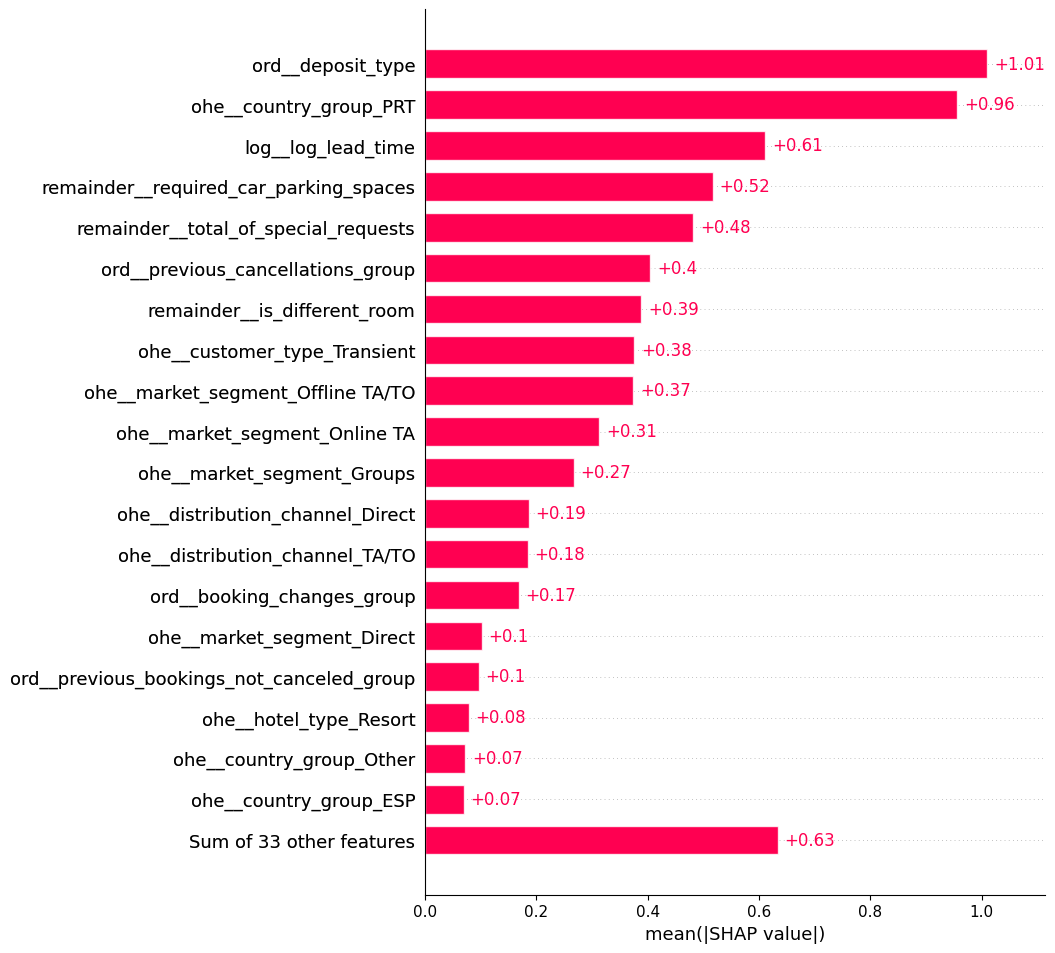

In [59]:
X_dev_trans = preprocessor.transform(X_dev)
X_train_trans = preprocessor.transform(X_train)

feature_names = preprocessor.get_feature_names_out()

explainer = shap.LinearExplainer(
    log_reg,
    X_train_trans,
    feature_names=feature_names
)

shap_values = explainer(X_dev_trans)

shap.plots.bar(shap_values, max_display=20)

**SHAP (SHapley Additive exPlanations)** đo lường mức độ đóng góp của từng thuộc tính vào dự đoán của mô hình.

Giá trị SHAP càng lớn -> thuộc tính càng quan trọng trong việc ảnh hưởng đến kết quả dự đoán.

Các thuộc tính có ảnh hưởng mạnh nhất
- ord__deposit_type (+1.01): Là thuộc tính quan trọng nhất, cho thấy loại đặt cọc ảnh hưởng lớn đến khả năng huỷ.

- ohe__country_group_PRT (+0.96): Quốc gia PRT (Bồ Đào Nha) có ảnh hưởng lớn đến hành vi khách hàng.

- log__log_lead_time (+0.61): Thời gian đặt trước càng dài, ảnh hưởng càng rõ đến kết quả.

- remainder__required_car_parking_spaces (+0.52): Nhu cầu chỗ đậu xe có liên quan chặt chẽ đến hành vi giữ đặt phòng.

- remainder__total_of_special_requests (+0.48): Số lượng yêu cầu đặc biệt cũng là yếu tố quan trọng.

Những thuộc tính này không chỉ có Odds Ratio cao mà còn có tác động thực tế lớn đến mô hình, được xác nhận qua SHAP.

### SHAP với 1 mẫu

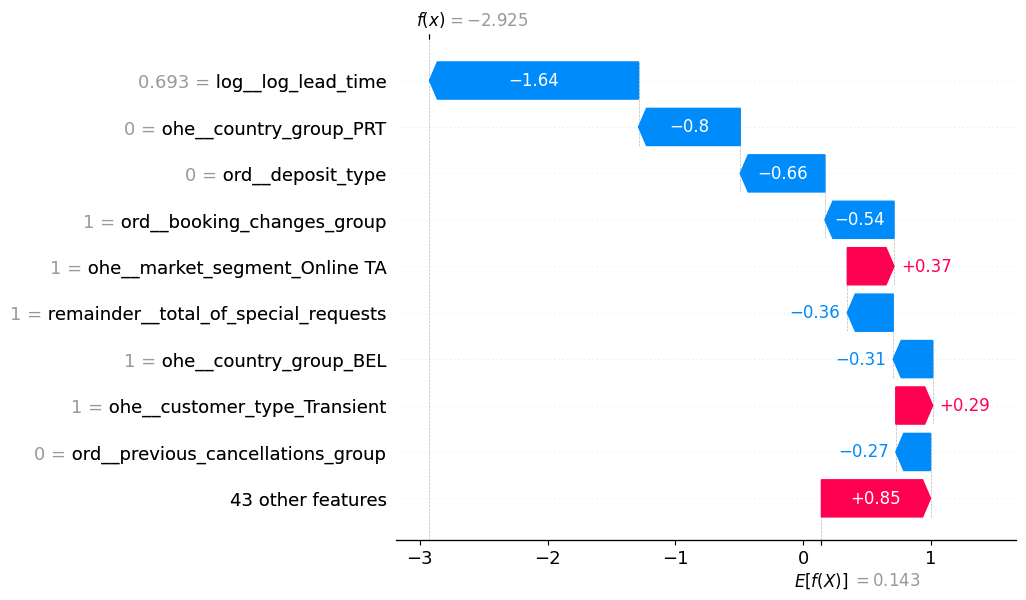

In [68]:
shap.plots.waterfall(
    shap.Explanation(
        values=shap_values.values[0],
        base_values=shap_values.base_values[0],
        data=X_dev_trans[0],
        feature_names=feature_names
    )
)

Giá trị kỳ vọng trên toàn bộ tập train của mô hình: 0.143

Dự đoán cho trường hợp này (1 mẫu trong dev): -2.925

Cho thấy mô hình nghiêng mạnh về phía không xảy ra sự kiện (không huỷ đặt phòng), do giá trị dự đoán thấp hơn nhiều so với kỳ vọng.

Các thuộc tính làm giảm dự đoán (SHAP âm)
- log__log_lead_time = 0.693: −1.64 -> Thời gian đặt trước dài làm giảm khả năng huỷ.

- country_group_PRT = 0: −0.8 -> Khách không đến từ PRT (Bồ Đào Nha), giảm rủi ro.

- deposit_type = 0: −0.66 -> Có thể là loại đặt cọc an toàn (ví dụ: có đặt cọc).

- booking_changes_group = 1: −0.54 -> Có thay đổi đặt phòng, nhưng lại làm giảm khả năng huỷ.

- total_of_special_requests = 1: −0.36 -> Có yêu cầu đặc biệt, thường gắn với khách nghiêm túc.

- country_group_BEL = 1: −0.31 -> Khách từ Bỉ có xu hướng ít huỷ.

- previous_cancellations_group = 0: −0.27 -> Không có lịch sử huỷ trước đó.

**Nhận xét tổng quát**:

Mô hình có tính giải thích tốt, với các thuộc tính quan trọng phản ánh đúng logic nghiệp vụ (ví dụ: đặt cọc, quốc gia, thời gian đặt trước).

# Lưu mô hình

In [60]:
import joblib

In [61]:
MODEL_PATH = '/content/drive/MyDrive/DS102 - Machine Learning/Hotel/models/'

joblib.dump(log_reg, MODEL_PATH + 'model_logreg.pkl')

['/content/drive/MyDrive/DS102 - Machine Learning/Hotel/models/model_logreg.pkl']